<img src='../../img/anaconda-logo.png' align='left' style="padding:10px">
<br>
*Copyright Continuum 2012-2016 All Rights Reserved.*

# Plotting Pitfalls

How do you plot 1 million or 1 billion data points in a scatter plot?

What is the best choice to accurately represent your data?
* `size`: large points occulude others, small ones are hard to see
* `alpha`: easily saturate
* `bins`: what subsample best represents the original data

Iterating through possible choices can be difficult or impossible.

## Table of Contents
* [Plotting Pitfalls](#Plotting-Pitfalls)
	* [Overplotting](#Overplotting)
	* [Oversaturation](#Oversaturation)
	* [Undersampling](#Undersampling)
	* [Binning](#Binning)
	* [Undersaturation](#Undersaturation)
* [Summary](#Summary)


## Set-Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Pitfalls of Plotting Many Points

Demonstration data:
* 2 sets of 300 random normal data points
* slight overlap between the two sets

In [2]:
def make_rnd(loc=(0.5,0.5), std=1.0, size=300, seed=1981):
    np.random.seed(seed+1)
    o_x, o_y = loc
    x = np.random.normal(o_x,std,size=size)
    y = np.random.normal(o_y,std,size=size)

    return pd.DataFrame({'x':x,'y':y})

In [3]:
blue = make_rnd(loc=(0.5,0.5))
red = make_rnd(loc=(-0.5,-0.5))

In [4]:
wp = pd.Panel({'blue':blue, 'red':red})
wp

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 300 (major_axis) x 2 (minor_axis)
Items axis: blue to red
Major_axis axis: 0 to 299
Minor_axis axis: x to y

How can we accurately convey this in a plot?

## Overplotting

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
*Overplotting* is the occlusion of important data.
</big></big>
<br><br>
</div>

Are there more red or blue in any region?

Which order of colors is correct?

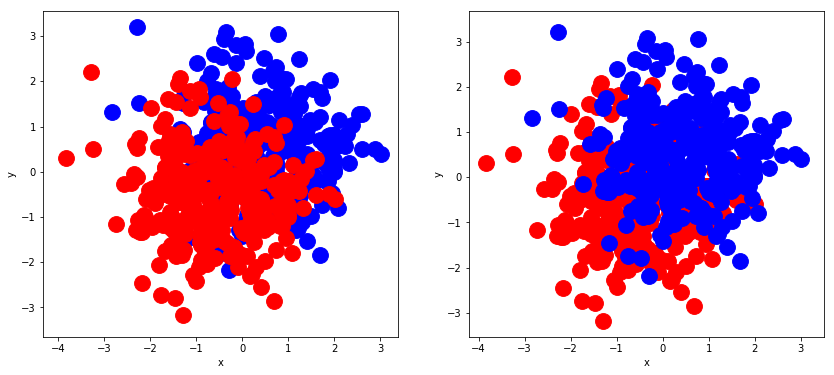

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

style = {'s':250}

for i in wp.items:
    wp[i].plot(kind='scatter', x='x', y='y', color=i, ax=axes[0], **style)
    
for i in reversed(wp.items):
    wp[i].plot(kind='scatter', x='x', y='y', color=i, ax=axes[1], **style)

## Oversaturation

By setting an `alpha` parameter you can avoid *overplotting*, but introduce *oversaturation*.

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
*Oversaturation* is settting the <tt>alpha</tt> parameter too high for the amount of data points.
</big></big>
<br><br>
</div>

With alpha=0.1, only 10 points are required to *saturate* the plot. 

Regions of more than 10 points are not accurately represented.

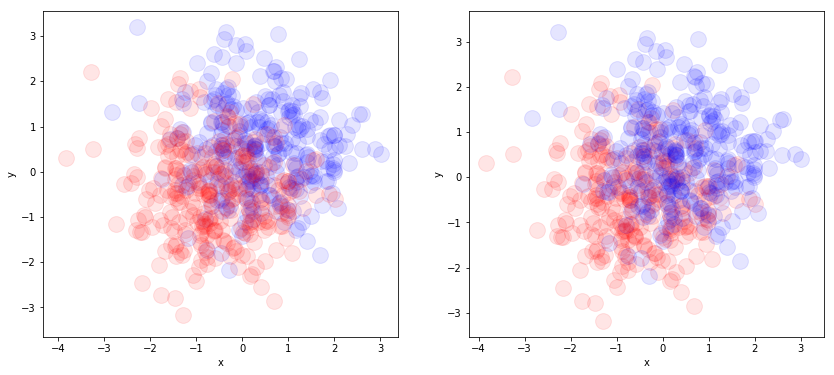

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

style = {'s':250, 'alpha':0.1}

for i in wp.items:
    wp[i].plot(kind='scatter', x='x', y='y', color=i, ax=axes[0], **style)
    
for i in reversed(wp.items):
    wp[i].plot(kind='scatter', x='x', y='y', color=i, ax=axes[1], **style)

<div class='alert alert-warning'>
For 600 points, `alpha=0.1` is too high.
</div>

In [7]:
blue = make_rnd(loc=(0.5,0.5), size=600)
red = make_rnd(loc=(-0.5,-0.5), size=600)
wp600 = pd.Panel({'blue':blue, 'red':red})

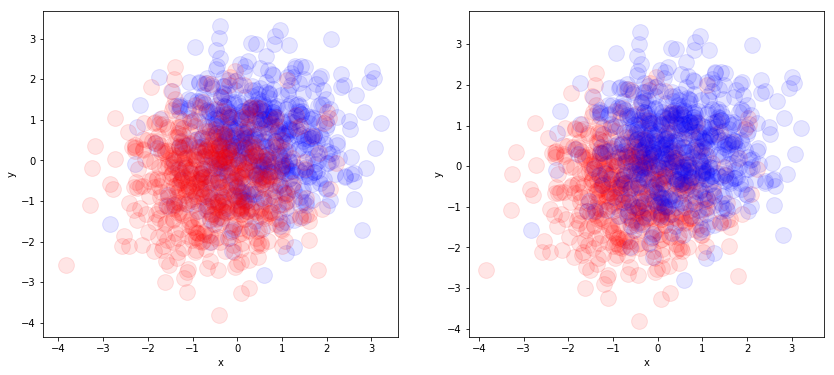

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

style = {'s':250, 'alpha':0.1}

for i in wp600.items:
    wp600[i].plot(kind='scatter', x='x', y='y', color=i, ax=axes[0], **style)
    
for i in reversed(wp600.items):
    wp600[i].plot(kind='scatter', x='x', y='y', color=i, ax=axes[1], **style)

## Undersampling

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
*Undersampling* is the removal of important features when visualizing less data.
</big></big>
<br><br>
</div>

Two very closely overlapping random normal distributions.

In [9]:
def make_node(offset=0.5, std=1.0, size=300, seed=1981):
    np.random.seed(seed)
    dfs = []
    for i in offset,-offset:
        x = np.random.normal(i,std,size=size)
        y = np.random.normal(0,std,size=size)
        dfs.append(pd.DataFrame({'x':x, 'y':y}))
    
    return pd.concat(dfs)

Take sample size of 600 and 60,000, and compare:

In [10]:
node = make_node(offset=1.5, size=60000)

With only 600 points the node may be slightly more discernable than visualizing all 60,000 points.

Narrative: how best to display the two over-lapping distributions. Trying several potential visual solutions, none looking all that great, until after iterating, using trial-and-error.

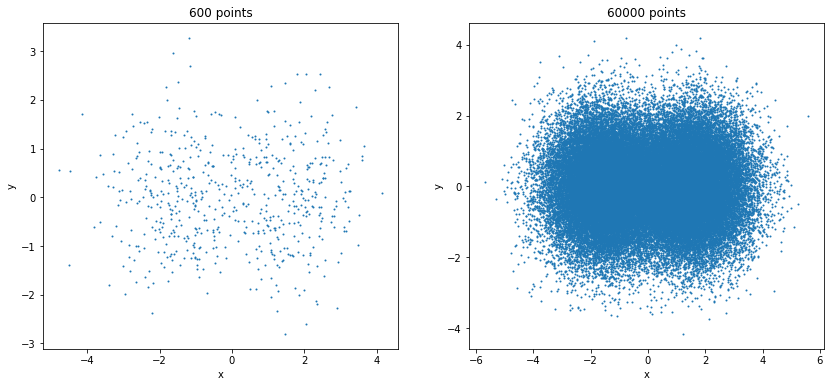

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

style = {'s':1, 'alpha':1.0}

for i,size in enumerate([600, 60000]):
    df = node.sample(size, random_state=2016)
    df.plot(kind='scatter', x='x', y='y', ax=axes[i], title='%d points' % size, **style)

Here, let's try using transparency... again, trial-and-error, until we get a visual representation that is true to the data.

Setting a low transparency only helps for many data points.

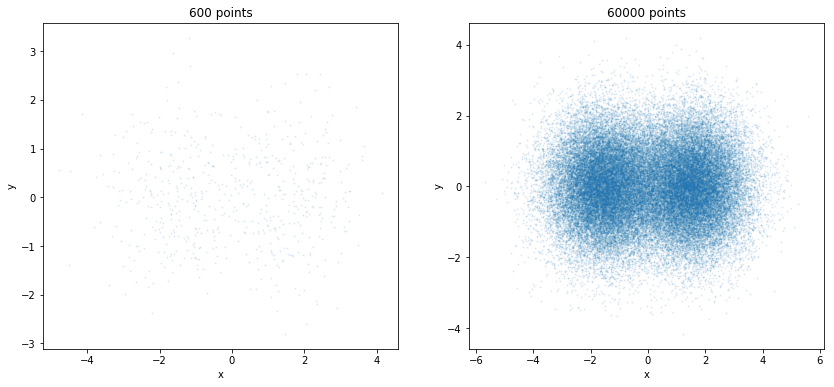

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))

style = {'s':1, 'alpha':0.1}

for i,size in enumerate([600, 60000]):
    df = node.sample(size, random_state=2016)
    df.plot(kind='scatter', x='x', y='y', ax=axes[i], title='%d points' % size, **style)

## Binning 

Another possible solution to some of these pit-falls. With malice of forethought, let's explore this since it is the strategy that Datashader uses...

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
*Binning* the data set requires knowing the optimal number of bins.
</big></big>
<br><br>
</div>

The `hexbin` method has reasonable default bin values.

Try three cases:

* 6 bins is likely too few. Cannot see the separation of the distributions.
* 20 is okay
* 200 may be the best we can do.

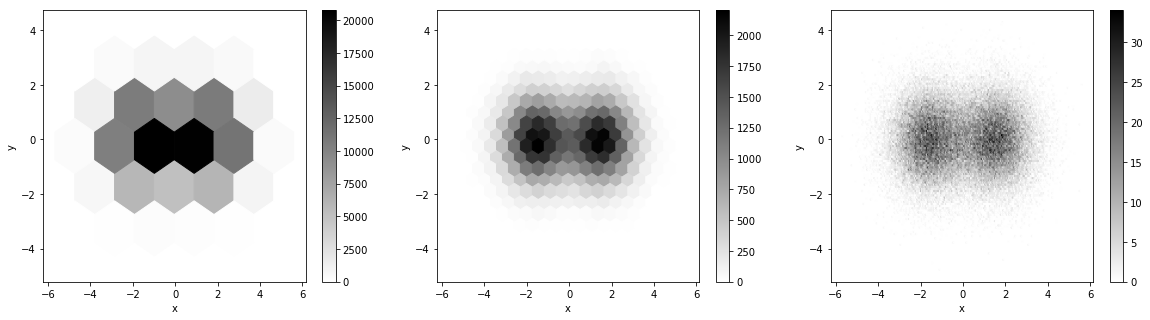

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

for ax,bins in zip(axes, [6, 20, 200]):
    node.plot(kind='hexbin', x='x', y='y', gridsize=bins, cmap='binary', ax=ax)

The problem is even worse if you want to interactively "zoom" in and out on your data.

If you zoomed into the 200 bin example, you would see maybe 1 point per bin, if the bin coverage mismatched the data, so you'd have to resample depending on the zoom.

## Undersaturation

<div class='alert alert-info'>
<img src='img/topics/Essential-Concept.png' align='left' style='padding:10x'>
<br>
<big><big>
*Undersaturation* is not being able to distinguish embedded regions of high and low density.
</big></big>
<br><br>
</div>

A cluster of **5** random normal distributions.

In [14]:
size = 10000
s1 = make_rnd(loc=(-2,-2), std=0.5,  size=size)
s2 = make_rnd(loc=(2,-2),  std=0.1,  size=size)
s3 = make_rnd(loc=(2,2),   std=0.01, size=size)
s4 = make_rnd(loc=(-2,2),  std=1.0,  size=size)
s5 = make_rnd(loc=(0,0),   std=2,    size=size)

df5 = pd.concat([s1,s2,s3,s4,s5], ignore_index=True)

Which value of alpha is appropriate? A really small `alpha` can obscure the larger distribution centered at zero.

Let's try three values of alpha to demonstrate:

* alpha = 0.5
* alpha = 0.1
* alpha = 0.01

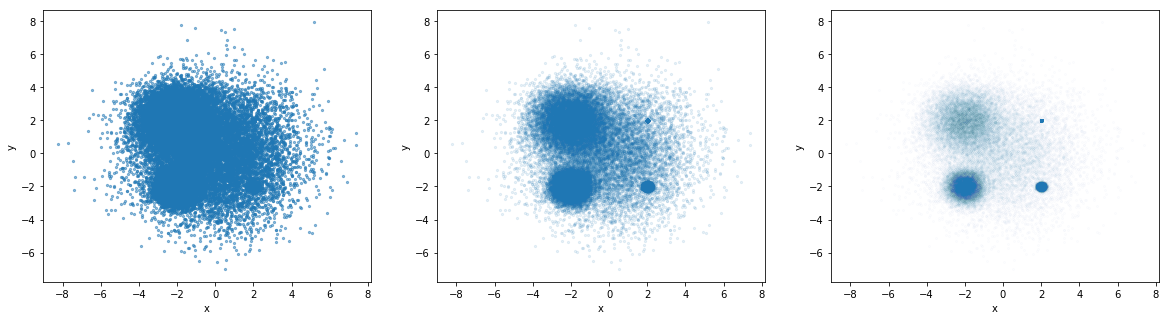

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

for alpha,ax in zip([0.5,0.1,0.01], axes):
    df5.plot(kind='scatter', x='x', y='y', ax=ax, alpha=alpha, s=5)

Undersaturation is also a concern when binning. If you make the bin too large, there are a small number of points within the bin, likely resulting in a misrepresentation of the region bounded by the bin.

Binning is difficult due to the rapid changes in density.

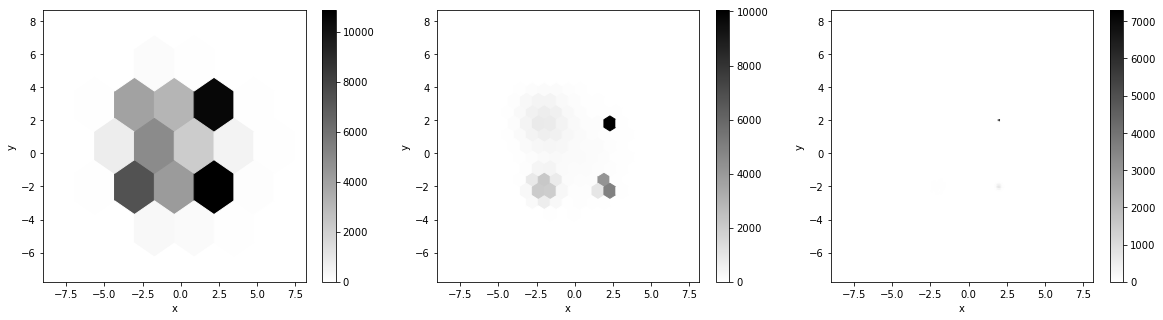

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

for ax,bins in zip(axes, [6, 20, 200]):
    df5.plot(kind='hexbin', x='x', y='y', gridsize=bins, cmap='binary', ax=ax)    

We can do better, addressing the undersaturation problme with binning, but again it is trial-and-error. By transforming the grey-scale mapping as a logarithm, we can represent the spread in densities better across the three bin sizes.

It's still a bit difficult to see the distribution in the top left corner.

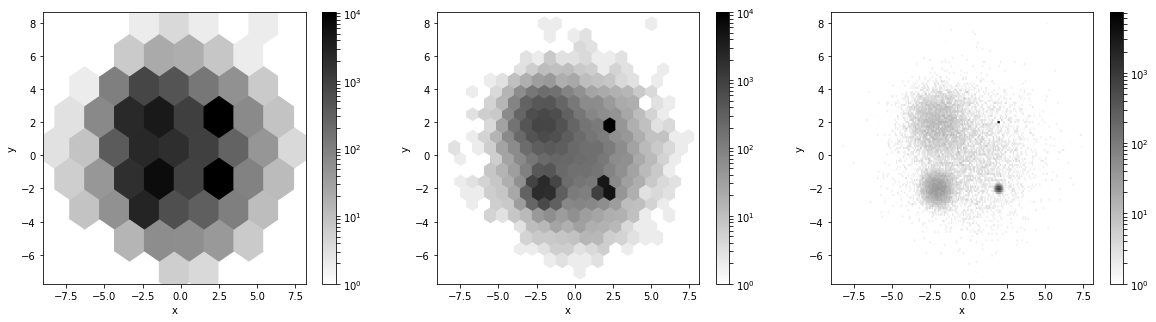

In [17]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(ncols=3, figsize=(20,5))

for ax,bins in zip(axes, [8, 20, 200]):
    df5.plot(kind='hexbin', x='x', y='y', norm=LogNorm(), gridsize=bins, cmap='binary', ax=ax) 

# Summary

<div class='alert alert-success'>
<img src='img/topics/Best-Practice.png' align='left' style='padding:10x'>
<br>
<big><big>
Your data might be lying to you.
</big></big>
<br><br>
</div>

<div class='alert alert-success'>
<img src='img/topics/Best-Practice.png' align='left' style='padding:10x'>
<br>
<big><big>
To fix the visualization problems often takes a lot of trial-and-error, and only provides a specific solution.
</big></big>
<br><br>
</div>

Making the right choice between these options is time-consuming and error prone.
* alpha
* size
* bins
* scales
* color mapping
* subsamples

While you might develop good values for one visualization you might have to start over when you
* make the plot larger or smaller
* change the color mapping
* try plotting a different dataset

----
<a href='./Datashader_pipeline.ipynb' class='btn btn-primary'>Datashader Pipeline</a>

---
*Copyright Continuum 2012-2016 All Rights Reserved.*